In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import boto3
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import io
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input


class S3ImageGenerator(Sequence):
    def __init__(self, bucket, prefix, split=True, batch_size=32, target_size=(299, 299), class_mode='binary', subset='training', split_ratio=0.9):
        self.s3 = boto3.client('s3')
        self.bucket = bucket
        self.prefix = prefix
        self.split = split
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.subset = subset
        all_keys, all_labels = self._gather_keys_labels()
        self.index = 0
        # Splitting the data
        if split:
            keys_train, keys_val, labels_train, labels_val = train_test_split(
                all_keys, all_labels, test_size=(1 - split_ratio), random_state=42)

            if self.subset == 'training':
                self.image_paths = keys_train
                self.labels = labels_train
            elif self.subset == 'validation':
                self.image_paths = keys_val
                self.labels = labels_val
        else:
            self.image_paths = all_keys
            self.labels = all_labels

    def _gather_keys_labels(self):
        keys = []
        labels = []
        paginator = self.s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=self.bucket, Prefix=self.prefix)
        for page in pages:
            for obj in page['Contents']:
                key = obj['Key']
                if key.endswith('.jpg') or key.endswith('.png'):  # Ensure it's an image file
                    keys.append(key)
                    parts = key.split('/')
                    if 'noncovid' in parts:
                        label = 0
                    elif 'covid' in parts:
                        label = 1
                    labels.append(label)
        return keys, labels

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array([
            self._load_image(path) for path in batch_x]), np.array(batch_y)

    def _load_image(self, path):
        response = self.s3.get_object(Bucket=self.bucket, Key=path)
        image_content = response['Body'].read()
        image = Image.open(io.BytesIO(image_content))
        image = image.resize(self.target_size, Image.Resampling.LANCZOS)
        image = np.array(image)
        if image.ndim == 2:
            image = np.stack((image,) * 3, axis=-1)
        elif image.shape[2] == 1:  # Single channel
            image = np.concatenate((image, image, image), axis=-1)
        image = image / 255.0  # Normalize pixel values
        return image
bucket = 'covid19-ct-scan-proj'
prefix = 'train' 
# # Create training and validation generators
train_generator = S3ImageGenerator(bucket, prefix, split=True, subset='training', split_ratio=0.9)
validation_generator = S3ImageGenerator(bucket, prefix, split=True, subset='validation', split_ratio=0.9)



2024-08-10 16:16:22.818814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 16:16:22.834617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 16:16:22.858734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 16:16:22.858768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 16:16:22.873615: I tensorflow/core/platform/cpu_feature_gua

In [3]:
labels = train_generator.labels
keys = train_generator.image_paths
print('number of labels in training set: ', len(labels))
print('unique labels: ', np.unique(labels))
print('number of keys in training set: ', len(keys))

number of labels in training set:  95558
unique labels:  [0 1]
number of keys in training set:  95558


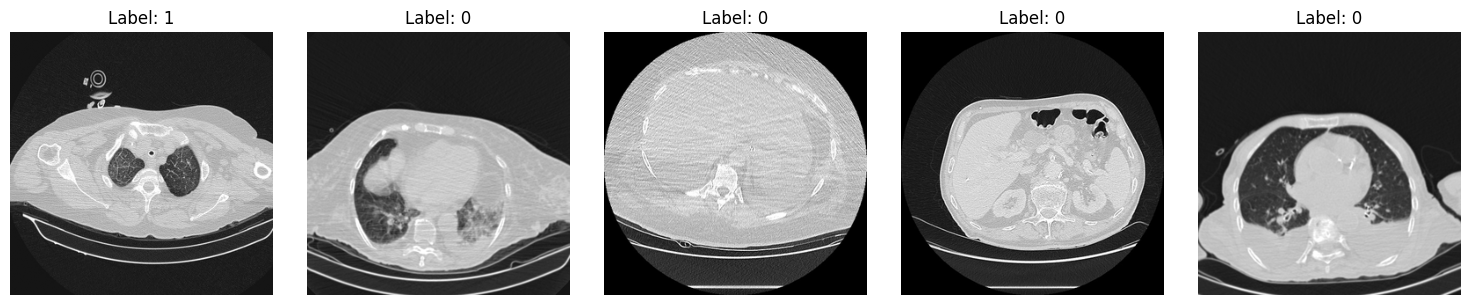

In [2]:
import matplotlib.pyplot as plt
images, labels = train_generator[0]

def plot_images(images, labels, nrows=1, ncols=5):
    """Plot a grid of images with labels."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Display image
            ax.imshow(images[i])
            # Title with the class label
            ax.set_title(f'Label: {labels[i]}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
    plt.tight_layout()
    plt.show()

plot_images(images, labels, nrows=1, ncols=5)  # Adjust ncols to display more images if needed


In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [1]:
import wandb
import os 

# Use your API key directly if it's secure to do so or fetch it from an environment variable
wandb.login(key=os.getenv("WANDB_API_KEY"))





Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lililiq888. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


True

In [4]:
import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger


# Initialize a new run
wandb.init(project="covid19-ct-scan", entity="lililiq888")

# Configure hyperparameters and other settings for your run
config = wandb.config
config.learning_rate = 1e-5
config.epochs = 15
config.batch_size = 32
config.input_shape = (299, 299, 3)  # model input shape


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD

def create_model(input_shape):
    # Load the pre-trained Inception V3 model without the top layer
    base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))

    # Freeze all layers in the pre-trained model to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers on top of the model for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
    # x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)  # Add a fully-connected layer with 512 units 
    x = Dropout(0.2)(x)  # Add a dropout layer for regularization
    predictions = Dense(1, activation='sigmoid')(x)  

    # Create the full model with the customized top layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with SGD optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=config.learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Specify the input shape to the model (height, width, channels)
input_shape = (299, 299, 3)  # Adjust based on your target_size in the image generator
model = create_model(config.input_shape)


2024-08-10 16:18:02.247450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 16:18:02.297176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-10 16:18:02.299382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
train_iterator = iter(train_generator)

images, labels = next(train_iterator)


print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)



Batch shape: (32, 299, 299, 3)
Labels shape: (32,)


In [6]:
# Define the checkpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Path to save the model file
    monitor='val_loss',  # Quantity to monitor (e.g., validation loss)
    verbose=1,  # Verbosity mode (0 or 1)
    save_best_only=True,  # Save only the best model according to the monitored quantity
    mode='min',  # Mode for the monitored quantity, 'min' for loss
    save_weights_only=False,  # Set to True to save only the model's weights
    save_freq='epoch'  # Save the model at the end of each epoch
)

In [7]:

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=config.epochs,  
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[WandbMetricsLogger()]
    callbacks=[WandbCallback(), checkpoint]
)
wandb.finish()


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15


2024-08-10 16:21:24.846707: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1723306888.524753    5430 service.cc:145] XLA service 0x7f7440109950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723306888.524790    5430 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-10 16:21:28.561391: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723306888.690545    5430 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2987/2987 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7064

/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 1: val_loss improved from inf to 0.49781, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6837s 2s/step - loss: 0.5646 - accuracy: 0.7064 - val_loss: 0.4978 - val_accuracy: 0.7663
Epoch 2/15
2987/2987 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.7743INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.5s



Epoch 2: val_loss improved from 0.49781 to 0.45263, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6475s 2s/step - loss: 0.4828 - accuracy: 0.7743 - val_loss: 0.4526 - val_accuracy: 0.7978
Epoch 3/15
2987/2987 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.7996INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 3: val_loss improved from 0.45263 to 0.42069, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6550s 2s/step - loss: 0.4451 - accuracy: 0.7996 - val_loss: 0.4207 - val_accuracy: 0.8163
Epoch 4/15
2987/2987 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8187INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 4: val_loss improved from 0.42069 to 0.39863, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6474s 2s/step - loss: 0.4141 - accuracy: 0.8187 - val_loss: 0.3986 - val_accuracy: 0.8257
Epoch 5/15
2987/2987 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8332INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 5: val_loss improved from 0.39863 to 0.36789, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6527s 2s/step - loss: 0.3882 - accuracy: 0.8332 - val_loss: 0.3679 - val_accuracy: 0.8467
Epoch 6/15
2987/2987 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8478INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 6: val_loss improved from 0.36789 to 0.34348, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6170s 2s/step - loss: 0.3633 - accuracy: 0.8478 - val_loss: 0.3435 - val_accuracy: 0.8582
Epoch 7/15
2987/2987 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.8604INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 7: val_loss improved from 0.34348 to 0.32009, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6330s 2s/step - loss: 0.3389 - accuracy: 0.8604 - val_loss: 0.3201 - val_accuracy: 0.8700
Epoch 8/15
2987/2987 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8720INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 8: val_loss improved from 0.32009 to 0.29917, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6058s 2s/step - loss: 0.3152 - accuracy: 0.8720 - val_loss: 0.2992 - val_accuracy: 0.8786
Epoch 9/15
2987/2987 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8818INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 9: val_loss improved from 0.29917 to 0.27665, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 5871s 2s/step - loss: 0.2925 - accuracy: 0.8818 - val_loss: 0.2767 - val_accuracy: 0.8903
Epoch 10/15
2987/2987 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.8921INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 10: val_loss improved from 0.27665 to 0.25743, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 5644s 2s/step - loss: 0.2716 - accuracy: 0.8921 - val_loss: 0.2574 - val_accuracy: 0.8988
Epoch 11/15
2987/2987 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9033INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.5s



Epoch 11: val_loss improved from 0.25743 to 0.24029, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 5554s 2s/step - loss: 0.2502 - accuracy: 0.9033 - val_loss: 0.2403 - val_accuracy: 0.9045
Epoch 12/15
2987/2987 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9115INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 12: val_loss improved from 0.24029 to 0.22284, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 5873s 2s/step - loss: 0.2324 - accuracy: 0.9115 - val_loss: 0.2228 - val_accuracy: 0.9127
Epoch 13/15
2987/2987 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9197INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 13: val_loss improved from 0.22284 to 0.20475, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6502s 2s/step - loss: 0.2148 - accuracy: 0.9197 - val_loss: 0.2048 - val_accuracy: 0.9227
Epoch 14/15
2987/2987 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9272INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.5s



Epoch 14: val_loss improved from 0.20475 to 0.18915, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6330s 2s/step - loss: 0.1985 - accuracy: 0.9272 - val_loss: 0.1892 - val_accuracy: 0.9286
Epoch 15/15
2987/2987 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9340INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets


INFO:tensorflow:Assets written to: /home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best/assets
wandb: Adding directory to artifact (/home/ubuntu/covid19-ct-scan/wandb/run-20240810_161745-uwtgymf3/files/model-best)... Done. 0.4s



Epoch 15: val_loss improved from 0.18915 to 0.17384, saving model to model_checkpoint.h5


/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 6234s 2s/step - loss: 0.1821 - accuracy: 0.9340 - val_loss: 0.1738 - val_accuracy: 0.9361


accuracy,▁▃▄▄▅▅▆▆▆▇▇▇███
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▅▄▄▃▃▃▂▂▂▁▁
val_accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇██
val_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
accuracy,0.934
best_epoch,14
best_val_loss,0.17384
epoch,14
loss,0.18212
val_accuracy,0.93615


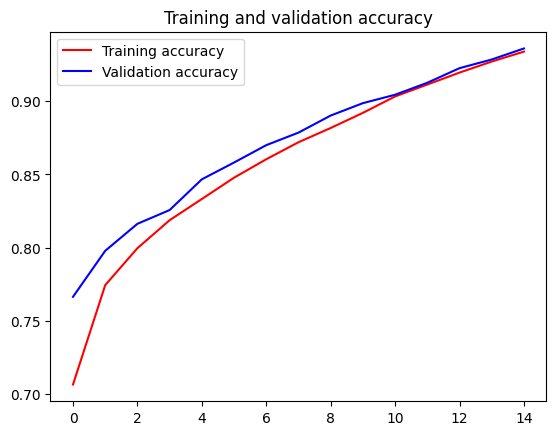

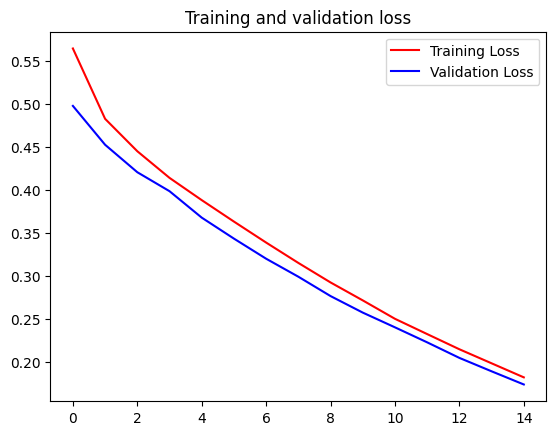

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

# Plot the training history
plot_training_history(history)


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Predict the probabilities
predictions = model.predict(validation_generator)

# If binary classification, you can use a threshold
predicted_labels = (predictions > 0.5).astype(int)



332/332 [==============================] - 555s 2s/step


F1 Score: 0.9323256612847819


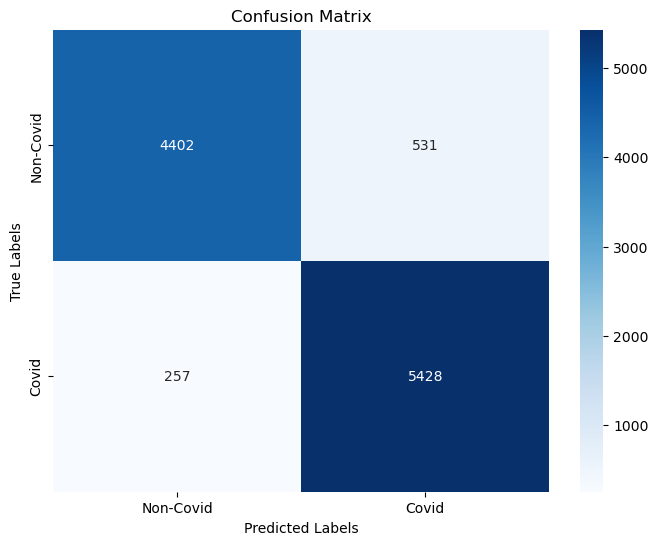

In [20]:
true_labels = validation_generator.labels
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Covid', 'Covid'], yticklabels=['Non-Covid', 'Covid'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [9]:
model.save("model_finetune_15e.h5")

/opt/tensorflow/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
model.save('my_model_15e.keras')